In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import numpy as np
from scipy.stats import zscore

import seaborn as sns



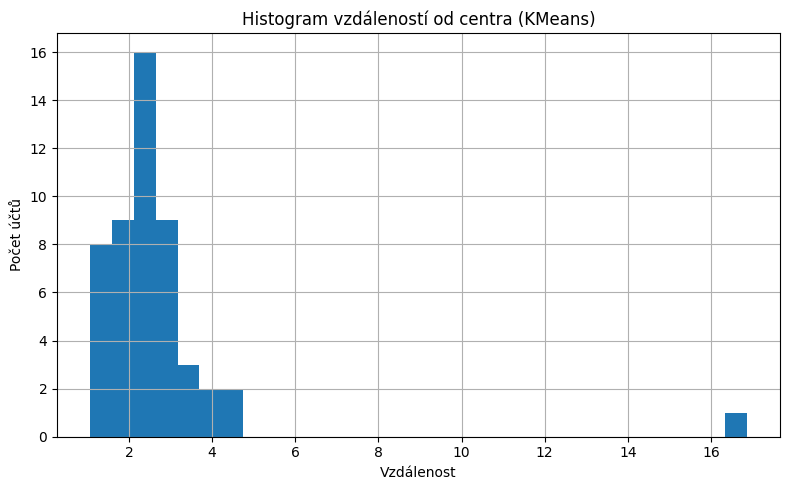

In [4]:
# Načtení dat
df = pd.read_csv("./data/accounts_summary.csv")
df.fillna(0, inplace=True)

# --- 1. Histogram vzdáleností od středu klastru (KMeans) ---
features = df.drop(columns=["Account"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=1, random_state=42)
kmeans.fit(X_scaled)
distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_, axis=1)
df["DistanceFromCenter"] = distances


# Histogram
plt.figure(figsize=(8, 5))
plt.hist(distances, bins=30)

plt.title("Histogram vzdáleností od centra (KMeans)")
plt.xlabel("Vzdálenost")
plt.ylabel("Počet účtů")
plt.grid(True)
plt.tight_layout()
plt.show()


/Users/pvacha/projects/tul/dm-money-laundering/jlab_env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/pvacha/projects/tul/dm-money-laundering/jlab_env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/pvacha/projects/tul/dm-money-laundering/jlab_env/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


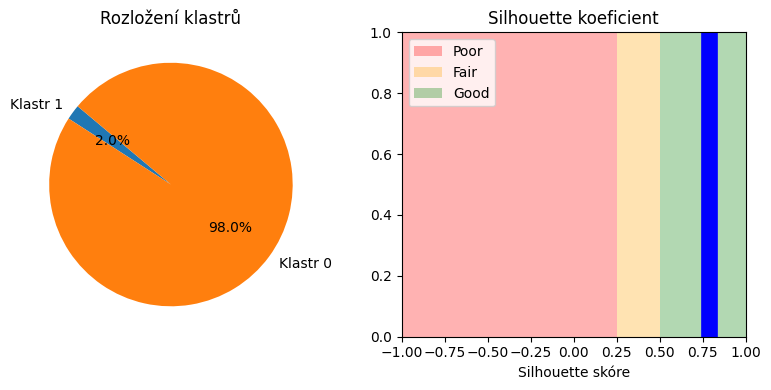

np.float64(0.7879573997319723)

In [20]:
# Počet účtů v každém klastru
cluster_counts = df["TwoStep_KMeans_Label"].value_counts().sort_values(ascending=True)

# Vytvoření podobného výstupu jako TwoStep ve SPSS Modeleru
labels = [f"Klastr {i}" for i in cluster_counts.index]
colors = ['#3498db', '#e74c3c']  # modrá a červená

# Zkusíme KMeans se dvěma klastry (imitace SPSS TwoStep)
kmeans_2 = KMeans(n_clusters=2, random_state=42)
labels_2 = kmeans_2.fit_predict(X_scaled)

# Přidání labelů do dataframe
df["TwoStep_KMeans_Label"] = labels_2


# Velikost klastrů a poměr
smallest_cluster_size = cluster_counts.iloc[0]
largest_cluster_size = cluster_counts.iloc[1]
ratio = largest_cluster_size / smallest_cluster_size

# Silhouette skóre pro kvalitu klastrů
sil_score = silhouette_score(X_scaled, labels_2)

# Výsečový graf klastrů
plt.figure(figsize=(8, 4))

# Subplot 1: Pie chart
plt.subplot(1, 2, 1)
plt.pie(cluster_counts, labels=[f"Klastr {i}" for i in cluster_counts.index], autopct='%1.1f%%', startangle=140)
plt.title("Rozložení klastrů")

# Subplot 2: Cluster quality
plt.subplot(1, 2, 2)
plt.axvline(sil_score, color='blue', linewidth=12)
plt.axvspan(-1.0, 0.25, facecolor='red', alpha=0.3, label='Poor')
plt.axvspan(0.25, 0.5, facecolor='orange', alpha=0.3, label='Fair')
plt.axvspan(0.5, 1.0, facecolor='green', alpha=0.3, label='Good')
plt.xlim(-1, 1)
plt.title("Silhouette koeficient")
plt.xlabel("Silhouette skóre")
plt.legend()
plt.tight_layout()
plt.show()

sil_score


In [17]:
# Výběr účtu z nejmenšího klastru (anomalie podle TwoStep-like modelu)
smallest_cluster_label = cluster_counts.index[0]
anomalous_twostep_kmeans = df[df["TwoStep_KMeans_Label"] == smallest_cluster_label]
anomalous_twostep_kmeans

,Account,Sum_In,Sum_Out,Mean_In,Mean_Out,Min_In,Min_Out,Max_In,Max_Out,SD_In,SD_Out,Count_In,Count_Out,DistanceFromCenter,TwoStep_KMeans_Label
36,10004000,1222162,1832956,15470.405063,15148.396694,10054,10039,19986,19992,2997.915308,2861.548708,79,121,16.866989,1


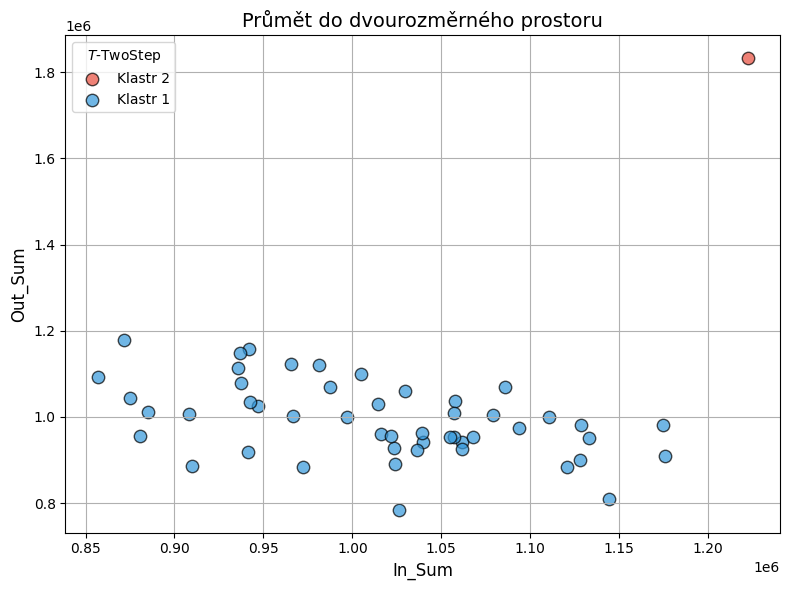

In [19]:
# 2D scatter plot ve stylu SPSS obrázku 1-10 – In vs Out Sum
plt.figure(figsize=(8, 6))
for label in cluster_counts.index:
    cluster_data = df[df["TwoStep_KMeans_Label"] == label]
    plt.scatter(
        cluster_data["Sum_In"],
        cluster_data["Sum_Out"],
        s=80,
        label=f"Klastr {label + 1}",
        edgecolors='black',
        alpha=0.7,
        marker='o' if label == 0 else 'o',
        c=colors[label]
    )

plt.xlabel("In_Sum", fontsize=12)
plt.ylabel("Out_Sum", fontsize=12)
plt.title("Průmět do dvourozměrného prostoru", fontsize=14)
plt.legend(title="$T$-TwoStep")
plt.grid(True)
plt.tight_layout()
plt.show()

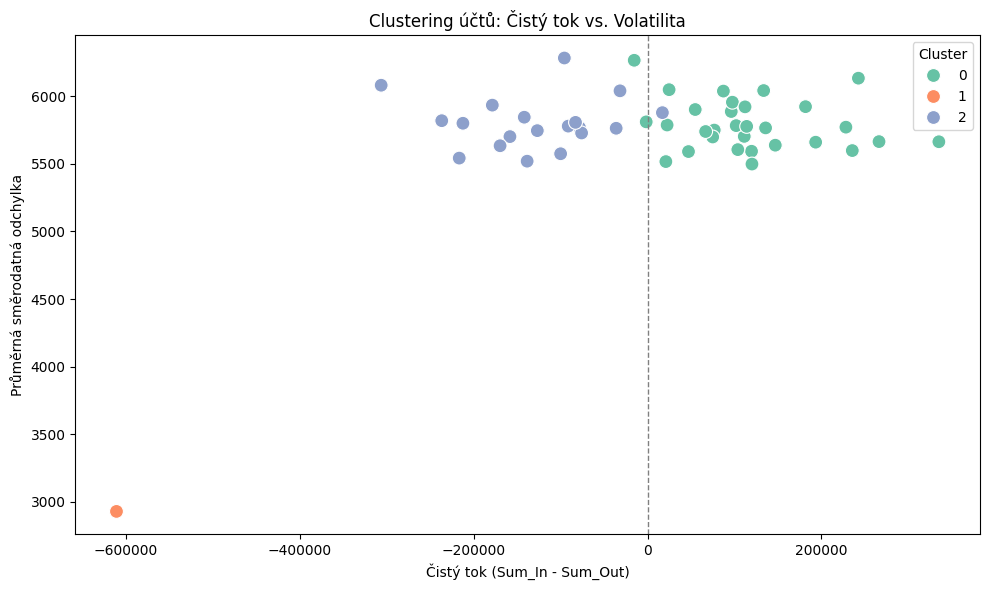

In [11]:

# Klastr 0: běžné účty (vyvážený tok, průměrné hodnoty)
# Klastr 1: účty s vysokou volatilitou nebo extrémními hodnotami (sus účty)
# Klastr 2: účty s nevyváženým tokem nebo neobvyklou aktivitou   (účty co se na tom podílejí)

# Výpočet čistého toku
df["Net_Flow"] = df["Sum_In"] - df["Sum_Out"]

df["In_per_Transaction"] = df["Sum_In"] / df["Count_In"]
df["Out_per_Transaction"] = df["Sum_Out"] / df["Count_Out"]
df["Avg_SD"] = (df["SD_In"] + df["SD_Out"]) / 2

features_for_clustering = df[[
    "Net_Flow", "SD_In", "SD_Out",
    "In_per_Transaction", "Out_per_Transaction"
]]
scaled_features = scaler.fit_transform(features_for_clustering)

kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="Net_Flow",
    y="Avg_SD",
    hue="Cluster",
    palette="Set2",
    data=df,
    s=100
)
plt.axvline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Clustering účtů: Čistý tok vs. Volatilita")
plt.xlabel("Čistý tok (Sum_In - Sum_Out)")
plt.ylabel("Průměrná směrodatná odchylka")
plt.tight_layout()
plt.show()